# Multilingual Named Entity Recognition (NER)
Based on "NLP with Transformers - Chapter 4"

NER - Token classification task, that classifies each word on the input.
Multilingual transformers - trained using masked language modeling task; they enable zero-shot cross-lingual transfer

Multilingual transformers are usually evaluated in 3 different ways
* `en` - fine-tune on English, and then evaluate on each language's test set
* `each` - fine-tune and evaluate on data from the same language to measure per-language performance
* `all` - fine-tune on all training data and evaluate on each language's test set

## PAN-X dataset
`PAN-X` (or `WikiANN`) is a subset of the `XTREME` benchmark, which consists of Wikipedia articles
Each article is annotated using IOB2 format:
* LOC - location
* PER - person
* ORG - organization
`B-` prefix indicates beginning of an entity, `I-` prefix continuation of an entity name 

In [1]:
import pandas as pd
import torch.nn
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names('xtreme')
xtreme_subsets = list(filter(lambda s: s.startswith('PAN'), xtreme_subsets))
xtreme_subsets[:5]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de']

In [2]:
from datasets import load_dataset

panx_en = load_dataset('xtreme', name='PAN-X.en')
panx_en

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

#### use english for fine-tuning and german for evaluation

In [3]:
SEED = 42

LANGS = ['en', 'de']

# limit no. of samples for simplicity
MAX_SAMPLES = {
    'train': 5_000,
    'validation': 1_000,
    'test': 1_000,
}

In [4]:
from datasets import DatasetDict

panx_ds = {}
for l in LANGS:
    ds = load_dataset('xtreme', name=f'PAN-X.{l}')
    ds_dict = DatasetDict()
    for split in ds:
        subset = ds[split].shuffle(SEED).select(range(MAX_SAMPLES[split]))
        ds_dict[split] = subset
    panx_ds[l] = ds_dict

panx_ds

{'en': DatasetDict({
     train: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 5000
     })
     validation: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 1000
     })
     test: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 1000
     })
 }),
 'de': DatasetDict({
     train: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 5000
     })
     validation: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 1000
     })
     test: Dataset({
         features: ['tokens', 'ner_tags', 'langs'],
         num_rows: 1000
     })
 })}

In [5]:
panx_en = panx_ds['en']
display(panx_en['train'])
display(panx_en['train'].features)
display(panx_en['train'].features['ner_tags'])

# add human-readable ner tags
i2tag = panx_en['train'].features['ner_tags'].feature

def add_readable_ner_tags(batch):
    return {
        "ner_tags_str": [i2tag.int2str(i) for i in batch['ner_tags']]
    }


panx_en = panx_en.map(add_readable_ner_tags)
panx_en

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 5000
})

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 1000
    })
})

In [6]:
# display single training sample
en_sample = panx_en['train'][0]
display(en_sample)

en_sample_pd = pd.DataFrame([en_sample['tokens'], en_sample['ner_tags_str']], index=['text', 'ner tags'])
display(en_sample_pd)

{'tokens': ["''",
  'January',
  '21',
  "''",
  '–',
  'Nanny',
  'and',
  'the',
  'Professor'],
 'ner_tags': [0, 0, 0, 0, 0, 1, 2, 2, 2],
 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'],
 'ner_tags_str': ['O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER']}

0        1   2   3  4      5      6      7          8
text      ''  January  21  ''  –  Nanny    and    the  Professor
ner tags   O        O   O   O  O  B-PER  I-PER  I-PER      I-PER

In [7]:
# check if tags are balanced
from collections import defaultdict, Counter

start_tags = set(map(lambda s: s[0],
                      filter(lambda t: t[1].startswith('B-'),
                             enumerate(i2tag.names)
                             )
                      )
                  )

tags_freq = defaultdict(Counter)
for split, ds in panx_en.items():
    for row in ds['ner_tags']:
        for tag in row:
            if tag in start_tags:
                tags_freq[split][i2tag.int2str(tag)] +=1 
pd.DataFrame.from_dict(tags_freq, orient='index')

B-PER  B-LOC  B-ORG
train        2266   2338   2396
validation    470    504    479
test          465    476    490

## XLM-RoBERTa (XLM-R) model
* Decoder-only, multilingual transformer
* Based on XLM and RoBERTa
    * RoBERTa - improved BERT (trained longer on larger batches, and only on MLM task)
    * XLM -  multilingual decoder transformer, trained on multiple tasks (language modeling, MLM, translation language modeling)
* XML-R is trained only using MLM task on a large corpus (Wiki + CC)

In [8]:
xlmr_model_name = 'xlm-roberta-base'

### Tokenization
XML-R uses SentencePiece tokenization

In [9]:
from transformers import AutoTokenizer, AutoConfig, AutoModel

xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
xlmr_tokenizer

XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [10]:
tokenized_sample = xlmr_tokenizer(en_sample['tokens'], is_split_into_words=True)
display(tokenized_sample)
display(tokenized_sample.tokens())
display(tokenized_sample.word_ids())

{'input_ids': [0, 5106, 18982, 952, 5106, 46, 37226, 299, 136, 70, 43552, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

['<s>',
 "▁''",
 '▁January',
 '▁21',
 "▁''",
 '▁–',
 '▁Nan',
 'ny',
 '▁and',
 '▁the',
 '▁Professor',
 '</s>']

[None, 0, 1, 2, 3, 4, 5, 5, 6, 7, 8, None]

In [11]:
import torch
ignored_tok = torch.nn.CrossEntropyLoss().ignore_index

def transform_dataset(ds):
    # tokenize words
    toks = xlmr_tokenizer(ds['tokens'], is_split_into_words=True, truncation=True)
    
    # align ner labels to tokens
    batch_labels = []
    for i, ner_tags in enumerate(ds['ner_tags']):
        word_ids = toks.word_ids(batch_index = i)
        
        prev_word = None
        labels = []
        for word_id in word_ids:
            if word_id is None:
                # no corresponding word in the input for the tag (e.g. BOS token)
                labels.append(ignored_tok)
            elif word_id == prev_word:
                labels.append(ignored_tok)
            else:
                labels.append(ner_tags[word_id])
            prev_word = word_id
        batch_labels.append(labels)
    
    toks['labels'] = batch_labels
    return toks

transform_dataset(panx_en['train'][:3])         

{'input_ids': [[0, 5106, 18982, 952, 5106, 46, 37226, 299, 136, 70, 43552, 2], [0, 1784, 33480, 44534, 15, 6653, 191, 20526, 45385, 8710, 34, 1388, 2], [0, 4794, 111, 9098, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, 0, 0, 1, -100, 2, 2, 2, -100], [-100, 5, -100, -100, 0, 0, -100, -100, -100, -100, -100, 0, -100], [-100, 3, 4, 4, -100]]}

In [12]:
panx_en_encoded = panx_en.map(transform_dataset, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])
panx_en_encoded

DatasetDict({
    train: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

### XLM-R Model

In [13]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

class XMLRforNer(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        
        # body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        # init weights
        self.init_weights()
        
    def forward(self, 
                input_ids = None, 
                attention_mask = None, 
                token_type_ids = None, 
                labels = None, 
                **kwargs):
        outputs = self.roberta(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids, **kwargs)
        h = outputs[0]
        h = self.dropout(h)
        logits = self.classifier(h)
        
        # loss
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, self.num_labels), labels.view(-1))
        else:
            loss = None
            
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

In [14]:
from transformers import AutoConfig

id2ner_tag = i2tag.names
ner_tag2id = {t: i for i, t in enumerate(id2ner_tag)}
display(i2tag.num_classes)
display(id2ner_tag)
display(ner_tag2id)

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels=i2tag.num_classes,
                                   id2label=id2ner_tag, label2id=ner_tag2id)

7

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6}

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xlmr_model = XMLRforNer.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

Some weights of XMLRforNer were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
panx_en_encoded_torch = panx_en_encoded['train'].with_format("torch", device=device)

In [17]:
# test model on a single batch
input_sample_torch = panx_en_encoded_torch[0]['input_ids']
display(input_sample_torch)
# input_sample_decoded = xlmr_tokenizer.decode(input_sample_torch, skip_special_tokens=True)
input_sample_decoded = xlmr_tokenizer.convert_ids_to_tokens(input_sample_torch)
display(input_sample_decoded)
input_sample_torch = torch.unsqueeze(input_sample_torch, 0)
display(input_sample_torch.shape)

outputs = xlmr_model(input_sample_torch)
display(outputs)
display(outputs.logits.shape)

predictions = torch.argmax(outputs.logits, dim=2)
predictions = predictions[0]
display(predictions)


predicted_tokens = [id2ner_tag[i] for i in predictions.cpu().numpy()]
display(predicted_tokens)

pd.DataFrame([input_sample_decoded, predicted_tokens])

tensor([    0,  5106, 18982,   952,  5106,    46, 37226,   299,   136,    70,
        43552,     2], device='cuda:0')

['<s>',
 "▁''",
 '▁January',
 '▁21',
 "▁''",
 '▁–',
 '▁Nan',
 'ny',
 '▁and',
 '▁the',
 '▁Professor',
 '</s>']

torch.Size([1, 12])

TokenClassifierOutput(loss=None, logits=tensor([[[ 0.2653,  0.1437,  0.5292,  0.0232, -0.2930, -0.1123,  0.4432],
         [-0.1770,  0.2252,  0.3101,  0.0985, -0.1361, -0.0427,  0.3267],
         [-0.2619,  0.1849,  0.2738,  0.0802, -0.1881, -0.0242,  0.2814],
         [-0.1904,  0.1566,  0.3039,  0.0713, -0.1403, -0.1010,  0.3283],
         [-0.1669,  0.2387,  0.3539,  0.1157, -0.1898, -0.0366,  0.3173],
         [-0.1464,  0.1611,  0.3169,  0.1149, -0.1157, -0.0713,  0.2848],
         [-0.1838,  0.1497,  0.3890,  0.0187, -0.2785, -0.0973,  0.2956],
         [-0.1229,  0.1280,  0.3733,  0.0716, -0.2775, -0.0353,  0.2558],
         [-0.1576,  0.1447,  0.2837, -0.0639, -0.1281, -0.0639,  0.3171],
         [-0.0557,  0.0911,  0.3344, -0.0568, -0.1426, -0.0681,  0.3399],
         [-0.1161,  0.1567,  0.4012,  0.0733, -0.2456, -0.0619,  0.2761],
         [ 0.2649,  0.1827,  0.5870,  0.0118, -0.2650, -0.1005,  0.3937]]],
       device='cuda:0', grad_fn=<ViewBackward0>), hidden_states=None, 

torch.Size([1, 12, 7])

tensor([2, 6, 6, 6, 2, 2, 2, 2, 6, 6, 2, 2], device='cuda:0')

['I-PER',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-LOC',
 'I-LOC',
 'I-PER',
 'I-PER']

0      1         2      3      4      5      6      7      8      9   \
0    <s>    ▁''  ▁January    ▁21    ▁''     ▁–   ▁Nan     ny   ▁and   ▁the   
1  I-PER  I-LOC     I-LOC  I-LOC  I-PER  I-PER  I-PER  I-PER  I-LOC  I-LOC   

           10     11  
0  ▁Professor   </s>  
1       I-PER  I-PER

## Fine-tuning

#### evaluation metrics

In [18]:
import evaluate
metric = evaluate.load("seqeval")
metric

EvaluationModule(name: "seqeval", module_type: "metric", features: {'predictions': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence')}, usage: """
Produces labelling scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: List of List of predicted labels (Estimated targets as returned by a tagger)
    references: List of List of reference labels (Ground truth (correct) target values)
    suffix: True if the IOB prefix is after type, False otherwise. default: False
    scheme: Specify target tagging scheme. Should be one of ["IOB1", "IOB2", "IOE1", "IOE2", "IOBES", "BILOU"].
        default: None
    mode: Whether to count correct entity labels with incorrect I/B tags as true positives or not.
        If you want to only count exact matches, pass mode="strict". default: None.
    sample_weight: Array-like of sha

In [19]:
import numpy as np

def compute_metrics(logits, targets):
    is_torch_tensor = isinstance(logits, torch.Tensor)
    if is_torch_tensor:
        preds = torch.argmax(logits, dim=2)
    else:
        preds = np.argmax(logits, axis=2)
    batch_size, seq_len = preds.shape
    
    display(batch_size)
    display(seq_len)
    
    ner_preds = []
    ner_labels = []
    for b in range(batch_size):
        sample_preds = []
        sample_labels = []
        for i in range(seq_len):
            pred = preds[b][i]
            label = targets[b][i]
            if is_torch_tensor:
                pred = pred.item()
                label = label.item()
            if label != ignored_tok:
                sample_preds.append(id2ner_tag[pred])
                sample_labels.append(id2ner_tag[label])

        ner_preds.append(sample_preds)
        ner_labels.append(sample_labels)

    return metric.compute(predictions=ner_preds, references=ner_labels, scheme='IOB2')

targets = panx_en_encoded_torch[0]['labels']
# display(targets)
compute_metrics(outputs.logits, [targets])

1

12

/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'LOC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'PER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.1111111111111111}

### Training XML-R

In [20]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 16
logging_steps = len(panx_en_encoded['train']) // batch_size
model_name = f'{xlmr_model_name}-finetuned_panx-en'

In [21]:
training_args = TrainingArguments(
    output_dir=model_name,
    log_level='info',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_steps=1e6,
    weight_decay=0.1,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False
)

In [22]:
# data collator for padding input
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [23]:
panx_en_encoded

DatasetDict({
    train: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['ner_tags_str', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [24]:
from transformers import Trainer

trainer = Trainer(
    model=xlmr_model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred.predictions, eval_pred.label_ids),
    train_dataset=panx_en_encoded['train'],
    eval_dataset=panx_en_encoded['validation'],
    tokenizer=xlmr_tokenizer
)

In [25]:
train_results = trainer.train()
train_results

The following columns in the training set don't have a corresponding argument in `XMLRforNer.forward` and have been ignored: ner_tags_str. If ner_tags_str are not expected by `XMLRforNer.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5,000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 939
  Number of trainable parameters = 277,458,439
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The following columns in the evaluation set don't have a corresponding argument in `XMLRforNer.forward` and have been ignored: ner_tags_str. If ner_tags_str are not expected by `XMLRforNer.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


1000

189

The following columns in the evaluation set don't have a corresponding argument in `XMLRforNer.forward` and have been ignored: ner_tags_str. If ner_tags_str are not expected by `XMLRforNer.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


1000

189

The following columns in the evaluation set don't have a corresponding argument in `XMLRforNer.forward` and have been ignored: ner_tags_str. If ner_tags_str are not expected by `XMLRforNer.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


1000

189



Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=939, training_loss=0.3680701166930925, metrics={'train_runtime': 140.411, 'train_samples_per_second': 106.829, 'train_steps_per_second': 6.688, 'total_flos': 254277734902752.0, 'train_loss': 0.3680701166930925, 'epoch': 3.0})

## Error analysis

In [76]:
first = [True]
cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')
num_labels=i2tag.num_classes

def forward_pass(batch):
    # convert dict of list to list of dict (required for data_collator)
    keys = list(batch.keys())        
    features = []
    for t in zip(*batch.values()):
        entry = dict(zip(keys, t))
        features.append(entry)
    
    features = data_collator(features)
    input_ids = features['input_ids'].to(device)
    attention_mask = features['attention_mask'].to(device)
    labels = features['labels'].to(device)
    
    # calculate predictions
    with torch.no_grad():
        outputs = trainer.model(input_ids, attention_mask)
        predictions = torch.argmax(outputs.logits, axis=-1).cpu().numpy()
        
    # calculate loss
    loss = cross_entropy_loss(outputs.logits.view(-1, num_labels), labels.view(-1))
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {
        'loss': loss,
        'predictions': predictions
    }
    
valid_set = panx_en_encoded['validation'].remove_columns('ner_tags_str').map(forward_pass, batched=True, batch_size=32)
valid_set

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'loss', 'predictions'],
    num_rows: 1000
})

In [77]:
valid_set_df = valid_set.to_pandas()
valid_set_df.head()

input_ids  \
0  [0, 5106, 235474, 14, 15491, 15619, 152, 106, ...   
1  [0, 353, 3459, 26708, 13, 78833, 5106, 339, 5,...   
2  [0, 4687, 1902, 39395, 5470, 678, 40137, 2548,...   
3  [0, 38348, 59338, 15, 1735, 38662, 192859, 138...   
4  [0, 636, 330, 122807, 242, 7, 314, 60635, 31, ...   

                                      attention_mask  \
0                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
1            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3                        [1, 1, 1, 1, 1, 1, 1, 1, 1]   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              labels  \
0         [-100, 0, 3, -100, 4, 4, 0, 0, 0, 0, -100]   
1  [-100, 5, -100, 6, -100, -100, 0, 0, -100, -10...   
2  [-100, 0, 0, 0, 0, 0, 1, 2, -100, 0, 0, 0, -10...   
3               [-100, 5, 6, 6, 6, -100, 6, 6, -100]   
4  [-100, 5, -100, -100, 6, -100, 6, -100, -100, ...   

                                                loss  \
0  [0.0, 0.0011943596, 0.07044787, 0.0, 0.1147166...   
1  [0.0, 1.1124653, 0.0, 0.3604024, 0.0, 0.0, 0.0...   
2  [0.0, 0.0005897928, 0.0005532165, 0.0010202685...   
3  [0.0, 0.024113588, 0.011042909, 0.012470839, 0...   
4  [0.0, 0.03152183, 0.0, 0.0, 0.04943069, 0.0, 0...   

                                         predictions  
0  [4, 0, 3, 4, 4, 4, 4, 4, 0, 0, 4, 0, 0, 0, 0, ...  
1  [0, 1, 5, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, ...  
3  [6, 5, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, ...  
4  [6, 5, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, ...

In [85]:
i2t_dic = {i: t for i, t in enumerate(id2ner_tag)}
i2t_dic[ignored_tok] = 'IGN'


valid_set_df['input_tokens'] = valid_set_df['input_ids'].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
valid_set_df['predicted_labels'] = valid_set_df['predictions'].apply(
    lambda x: [i2t_dic[i] for i in x]
)
valid_set_df['predicted_labels'] = valid_set_df.apply(
    lambda x: x['predicted_labels'][:len(x['input_ids'])], 
    axis=1
)
valid_set_df['ner_labels'] = valid_set_df['labels'].apply(
    lambda x: [i2t_dic[i] for i in x]
)
valid_set_df['loss_without_padding'] = valid_set_df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], 
    axis=1
)

valid_set_df.head(2)

input_ids  \
0  [0, 5106, 235474, 14, 15491, 15619, 152, 106, ...   
1  [0, 353, 3459, 26708, 13, 78833, 5106, 339, 5,...   

                            attention_mask  \
0        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   

                                              labels  \
0         [-100, 0, 3, -100, 4, 4, 0, 0, 0, 0, -100]   
1  [-100, 5, -100, 6, -100, -100, 0, 0, -100, -10...   

                                                loss  \
0  [0.0, 0.0011943596, 0.07044787, 0.0, 0.1147166...   
1  [0.0, 1.1124653, 0.0, 0.3604024, 0.0, 0.0, 0.0...   

                                         predictions  \
0  [4, 0, 3, 4, 4, 4, 4, 4, 0, 0, 4, 0, 0, 0, 0, ...   
1  [0, 1, 5, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                        input_tokens  \
0  [<s>, ▁'', ▁Bahrain, i, ▁FA, ▁Cup, ▁:, ▁1, ▁''...   
1  [<s>, ▁Na, via, ▁hub, e, riana, ▁'', ▁L, ., B,...   

                                    predicted_labels  \
0  [I-ORG, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, ...   
1  [O, B-PER, B-LOC, I-LOC, I-LOC, I-LOC, O, O, O...   

                                          ner_labels  \
0  [IGN, O, B-ORG, IGN, I-ORG, I-ORG, O, O, O, O,...   
1  [IGN, B-LOC, IGN, I-LOC, IGN, IGN, O, O, IGN, ...   

                                loss_without_padding  
0  [0.0, 0.0011943596, 0.07044787, 0.0, 0.1147166...  
1  [0.0, 1.1124653, 0.0, 0.3604024, 0.0, 0.0, 0.0...

In [93]:
tokens_df = valid_set_df[['input_tokens', 'ner_labels', 'predicted_labels', 'loss_without_padding']].apply(pd.Series.explode)
tokens_df = tokens_df.query("ner_labels != 'IGN'")
tokens_df = tokens_df.rename(columns={'loss_without_padding': 'loss'})
tokens_df['loss'] = tokens_df['loss'].astype(float).round(2)
tokens_df.head(5)

input_tokens ner_labels predicted_labels  loss
0          ▁''          O                O  0.00
0     ▁Bahrain      B-ORG            B-ORG  0.07
0          ▁FA      I-ORG            I-ORG  0.11
0         ▁Cup      I-ORG            I-ORG  0.10
0           ▁:          O            I-ORG  1.82

In [101]:
# aggregate by input tokens and sum the losses, to see which tokens caused most errors
(tokens_df
    .groupby('input_tokens')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1) #get rid of multi-level columns
    .sort_values(by='sum', ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
 )

0       1     2      3      4     5      6      7      8  \
input_tokens       ▁     ▁of   ▁''   ▁the     ▁(    ▁)   ▁and     ▁A     ▁'   
count            842     198   452    154    257   259    108     21    207   
mean            0.21    0.57  0.11    0.3   0.16  0.15   0.31   1.39   0.14   
sum           180.16  113.82  48.5  45.91  40.66  37.8  33.73  29.25  29.18   

                  9  
input_tokens   ▁New  
count            26  
mean           0.88  
sum           22.94

In [102]:
# aggregate by ner labels and sum the losses, to see which tokens caused most errors
(tokens_df
    .groupby('ner_labels')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1) #get rid of multi-level columns
    .sort_values(by='mean', ascending=False)
    .reset_index()
    .round(2)
    .T
 )

0       1       2       3       4      5       6
ner_labels   I-LOC   B-ORG   B-LOC   I-ORG   I-PER  B-PER       O
count          649     479     504    1163     754    470    4349
mean          0.88    0.74    0.59    0.55    0.43   0.39    0.08
sum         573.67  354.51  299.45  634.38  321.48  183.2  363.77

/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future vers

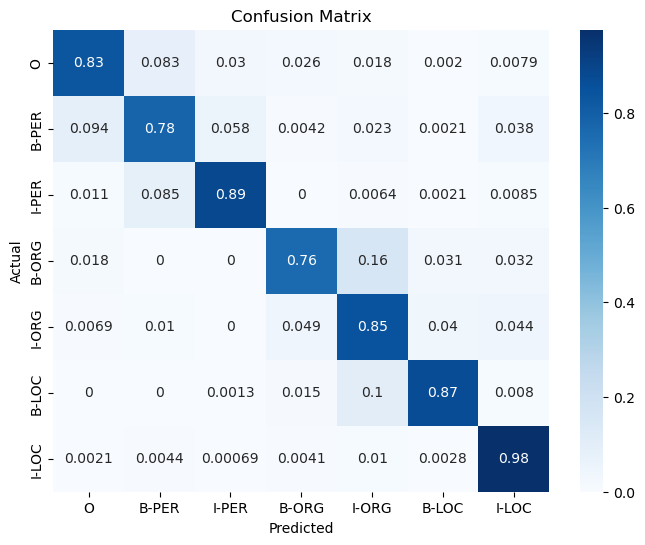

In [107]:
# confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(tokens_df['ner_labels'], tokens_df['predicted_labels'], normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=id2ner_tag, yticklabels=id2ner_tag)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Cross-Lingual zero-shot transfer learning
Evaluate NER model trained on English dataset on German dataset

In [108]:
panx_de = panx_ds['de']
panx_de_encoded = panx_de.map(transform_dataset, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])
panx_de_encoded

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [109]:
results = trainer.predict(panx_de_encoded['test'])
results

***** Running Prediction *****
  Num examples = 1000
  Batch size = 16


1000

73

PredictionOutput(predictions=array([[[ 1.1544487e+00, -4.3311083e-01,  6.6482618e-02, ...,
         -6.7442819e-02,  2.2462547e-01,  4.5335814e-01],
        [ 7.4211760e+00, -2.0091095e+00, -1.5173788e+00, ...,
         -6.6375524e-01, -1.4202708e+00, -1.6041708e+00],
        [ 6.0182271e+00, -9.3160337e-01, -2.1831923e+00, ...,
         -1.5626422e+00,  3.8854178e-02, -2.5020750e+00],
        ...,
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
        [-1.0000000e+02, -1.0000000e+02, -1.0000000e+02, ...,
         -1.0000000e+02, -1.0000000e+02, -1.0000000e+02]],

       [[ 2.0539868e+00,  4.6289306e-02,  8.3694327e-01, ...,
          3.2200526e-02, -6.6905266e-01, -3.6767113e-01],
        [ 7.3282776e+00, -1.5181772e+00, -1.8104911e+00, ...,
         -5.1767200e-01, -8.6266834e-01, -1.5780069e+0

In [110]:
m = results.metrics
display(m['test_overall_f1'])
display(m['test_overall_accuracy'])

0.72684246112238

0.9118257261410788